# IBM Attrition Prediction with a Ensemble Classifier

## Summary

To increase retention rates, HR might first identify the employees who might leave the company. This notebook built an ensemble model with the [IBM attrition data][1]* to predict high-risk employees and generated actionable insights. 

When I was working on this project, I learned a lot from [Anisotropic][2], [Aljaž][3], and [Vincent Lugat][4]'s work. 

Here are the steps I've taken:

1. **Load libraries and data**
2. **Explorative data analysis**
    * Examine Feature distribution and the distribution against employee attrition
3. **Data engineering**
    * Create new features and remove collinear ones
4. **Model Comparison**
    * Use F1 score as the metric to benchmark models
    * Interpret Feature Importance
    
Furture steps:
* Examine feature interactions and their impact on predictions

*Please note that this is a fictional dataset

[1]:https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset
[2]:https://www.kaggle.com/arthurtok/employee-attrition-via-ensemble-tree-based-methods
[3]:https://www.kaggle.com/aljaz91/ibm-s-attrition-tackling-class-imbalance-with-gbm
[4]:https://www.kaggle.com/vincentlugat/ibm-attrition-analysis-and-prediction

## 1. Load libraries and dataset
#### 1.1 Load libraries

In [1]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
from itertools import chain

from scipy.stats import chi2_contingency, zscore
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier)
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier


import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
pd.set_option('precision', 3) 

#### 1.2 Load Data

In [2]:
df = pd.read_csv('../input/WA_Fn-UseC_-HR-Employee-Attrition.csv')
sample_n, var_n = df.shape
print(f'This dataset contains {sample_n} samples and {var_n} varialbes')

This dataset contains 1470 samples and 35 varialbes


In [3]:
var_with_missing_values = df.columns[df.isnull().sum() > 0]
print(f'{len(var_with_missing_values)} variable has missing values')

0 variable has missing values


#### 1.3 Drop meaningless variables 
* Drop variables with only one value (EmployeeCount, StandardHours, Over18)
* Drop EmployeeNumber (ID)


In [4]:
cols_with_one_value = [col for col in df.columns if len(df[col].unique()) == 1]
to_drop = cols_with_one_value + ['EmployeeNumber']
df.drop(to_drop, axis=1, inplace=True)

#### 1.4 Separate different data types

* Separate features into three groups according to their data type (Measurement, Ordinal or Nominal).

In [5]:
measurement_vars = [col for col, dtype in df.dtypes.items() if dtype == 'int' and len(df[col].unique()) > 5]
ordinal_vars = [col for col, dtype in df.dtypes.items() if dtype == 'int' and len(df[col].unique()) <= 5]
nominal_vars = [col for col, dtype in df.dtypes.items() if dtype != 'int']
nominal_vars = nominal_vars[1:]

def print_vars(data_type, var_names):
    print(f'{data_type}:\n', ', '.join(var_names), end="\n\n")

print_vars('Measurement Data', measurement_vars)
print_vars('Ordinal Data', ordinal_vars)
print_vars('Nominal Data', nominal_vars)

Measurement Data:
 Age, DailyRate, DistanceFromHome, HourlyRate, MonthlyIncome, MonthlyRate, NumCompaniesWorked, PercentSalaryHike, TotalWorkingYears, TrainingTimesLastYear, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager

Ordinal Data:
 Education, EnvironmentSatisfaction, JobInvolvement, JobLevel, JobSatisfaction, PerformanceRating, RelationshipSatisfaction, StockOptionLevel, WorkLifeBalance

Nominal Data:
 BusinessTravel, Department, EducationField, Gender, JobRole, MaritalStatus, OverTime



#### 1.5 Rename feature levels

* Rename long descriptions with shorter abbreviations  

In [6]:
df['BusinessTravel'].replace({'Travel_Rarely': 'Rare',
                             'Travel_Frequently': 'Freq',
                             'Non-Travel': 'None'}, 
                             inplace=True)
df['Department'].replace({'Research & Development': 'R&D',
                          'Human Resources': 'HR'},
                            inplace=True)
df['EducationField'].replace({'Life Sciences': 'LifeSci',
                             'Medical': 'Med',
                             'Marketing': ' Mktg',
                             'Technical Degree': 'Tech',
                             'Human Resources': 'HR'},
                            inplace=True)
df['JobRole'].replace({'Sales Executive': 'SalesExec',
                      'Research Scientist': 'ResSci',
                      'Laboratory Technician': 'LabTech',
                      'Manufacturing Director': 'ManuDir',
                      'Healthcare Representative': 'HCRep',
                      'Sales Representative': 'SalesRep',
                      'Research Director': 'ResDir',
                      'Human Resources': 'HR'},
                     inplace=True)

#### 1.6 Split dataset 
* Split the dataset into a training set and a testing set
* Keep the proportion of values around the same level between the training and testing set

In [7]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
df_train = pd.concat([X_train, y_train], axis=1)

In [8]:
df_prop = pd.concat([y_train.value_counts()/ len(y_train),
          y_test.value_counts()/ len(y_test)],
          axis=1)
df_prop.columns = ['training', 'testing']
print(df_prop)

     training  testing
No      0.838     0.84
Yes     0.162     0.16


 
## 2. Explorative Analysis
#### 2.1 Feature distribution

In [9]:
def plot_EDA(df, cols, subplot_func, title=None, 
             sbp_info =(3,5), sbp_adj={},**kwargs):
    """
    plot feature distributions
    """
    n_col, subplot_size = sbp_info
    n_row = int(np.ceil(len(cols) / n_col))
    
    fig, ax = plt.subplots(n_row, n_col, 
                           figsize=(n_col * subplot_size, n_row * subplot_size))
    ax = ax.ravel()
    
    for i, col in enumerate(cols):
        subplot_func(df, col, ax[i], **kwargs)
    
    for ax in ax[len(cols):]:
        ax.axis('off')
        
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(**sbp_adj)
    

def feature_dist(df, col, ax):
    """
    subplot function
    """
    if isinstance(df[col][0], str):
        data = pd.DataFrame(df[col].value_counts()).reset_index()
        data.columns = [col, 'count']
    
        rotation = 0
        if sum(map(lambda x: len(x),list(data[col]))) > 20:
            rotation = 50

        sns.barplot(x=col, y='count', data = data , 
                alpha=0.4, ax=ax).set_title(col, fontsize=14)
    
        ax.set_xticklabels(ax.get_xticklabels(), 
                       fontsize=12,
                       rotation=rotation)
    else:
        sns.distplot(df[col], kde=False, ax=ax).set_title(col, fontsize=14)
        
    ax.set_xlabel('')   


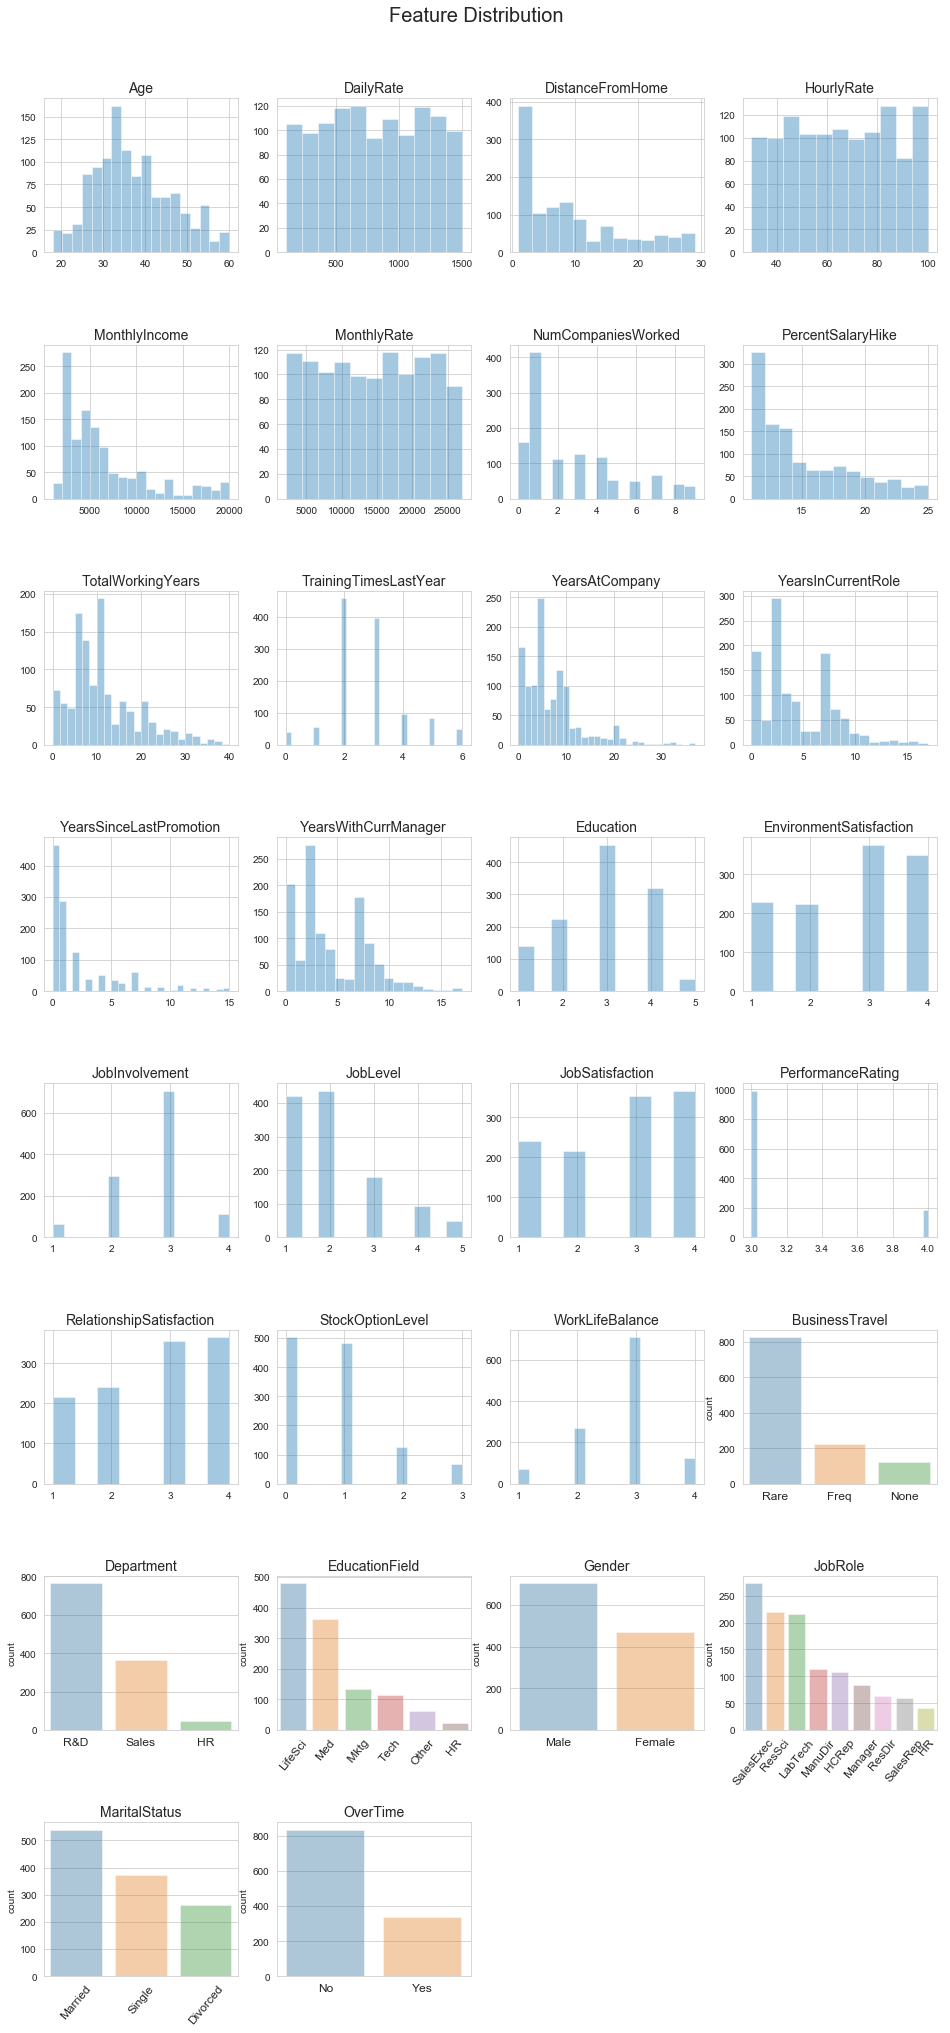

In [10]:
plot_EDA(X_train, 
         measurement_vars + ordinal_vars + nominal_vars,
         feature_dist, 
         title="Feature Distribution", 
         sbp_info=(4, 4),
         sbp_adj={'top': .94, 'hspace': .6})

**Takeaways**:

Many features showed skewed distributions. In section 3, we could recode those features into more symmetrical distributions.

#### 2.2 Distribution Against Employee Attrition

* Compared the distribution of each feature between the employees who have left their jobs and who stayed in the company.
* Features were sorted by the effect sizes of the comparison against Attrition, separately for different types of data.

In [11]:
def get_ES(df, cols, group=None):
    """
    get effect size
    """
    df = df[[group] + cols]
    means = df.groupby(group).mean().T
    std = df.groupby(group).std().T

    n1, n2 = df[group].value_counts().values
    cohen_d = ((means.values * [1, -1]).sum(axis=1) / 
          ((std.values ** 2 * [n1 -1, n2 -1]).sum(axis=1) / (n1 + n2 -2)) ** .5 )
    return dict(zip(cols, abs(cohen_d))) 

def get_chi2(df, cols, group=None):
    """
    get chi square (independence of variables)
    """
    cols_chi2 = []
    for col in cols:
        ct = pd.crosstab(df['Attrition'], df[col])
        chi2, _, _, _ = chi2_contingency(ct)
        cols_chi2.append(chi2)
    return dict(zip(cols, cols_chi2))

def sort_by_results(df, cols, func=None, group=None, with_value=False):
    """
    sort by the results of a given test
    """
    measure = func(df, cols, group=group)
    if with_value:
        return sorted(measure.items(), key=lambda x: x[1], reverse=True)
    else:
        return sorted(measure, key=measure.get, reverse=True)
    
def measurement_dist_against_attrition(df, col, ax):
    """
    distribution comparisons for measurement data 
    """
    sns.distplot(df.loc[df['Attrition']=='Yes', col], ax=ax).set_title(col, fontsize=14)
    sns.distplot(df.loc[df['Attrition']=='No', col], ax=ax)
    ax.set_xlabel('')
    #ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


def categorical_dist_against_attrition(df, col, ax):
    """
    distribution comparisons for categorical data 
    """
    ct = pd.crosstab(df['Attrition'], df[col]).apply(lambda r: r/r.sum(), axis=1)
    stacked = ct.stack().reset_index().rename(columns={0:'value'})
    
    rotation = 0
    if sum(map(lambda x: len(str(x)),list(stacked[col].unique()))) > 30:
        rotation = 40

    sns.barplot(x=stacked[col], y=stacked.value, 
                hue=stacked.Attrition, 
                alpha=.4, ax=ax).set_title(col, fontsize=14)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')

    
def dist_against_attrition(df, col, ax):
    if (not isinstance(df[col][0], str)) and len(df[col].unique()) > 6:
        measurement_dist_against_attrition(df, col, ax)
    else:
        categorical_dist_against_attrition(df, col, ax)



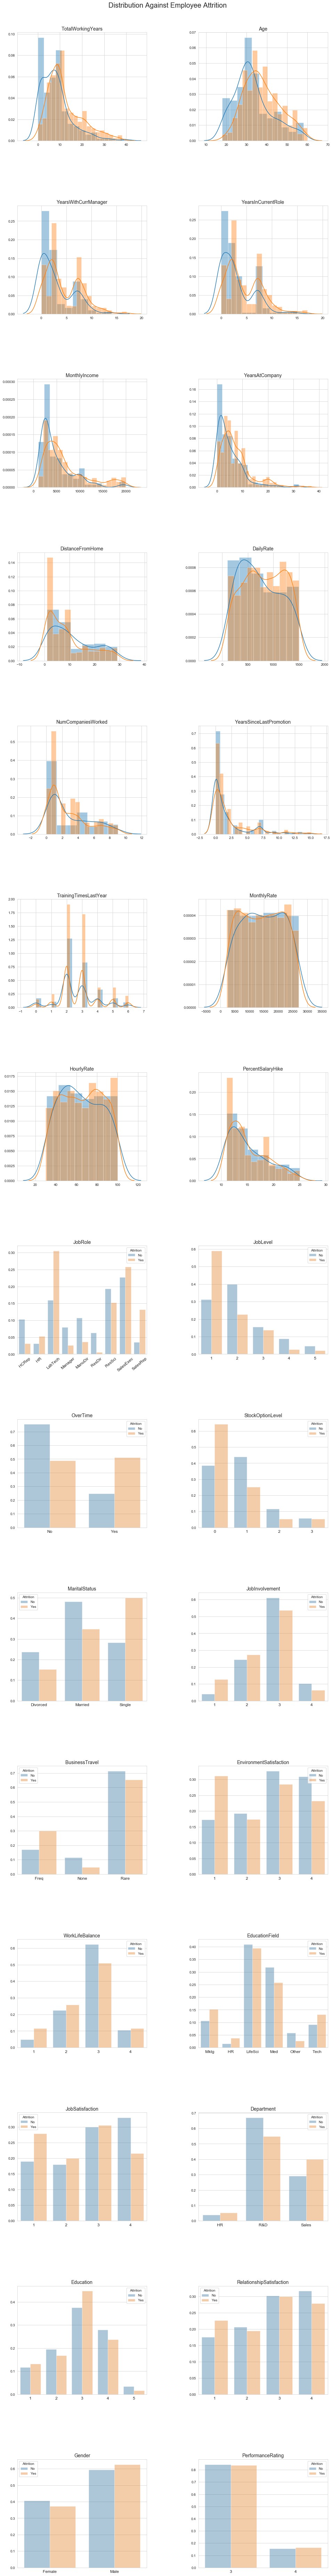

In [12]:
# sort features by the effect size of comparison on Attrition
sorted_measurement_vars = sort_by_results(df_train, measurement_vars, 
                                          func=get_ES, group='Attrition')
sorted_categorical_vars = sort_by_results(df_train, ordinal_vars + nominal_vars, 
                                      func=get_chi2, group='Attrition')


plot_EDA(df_train, sorted_measurement_vars + sorted_categorical_vars, 
         dist_against_attrition,
         title="Distribution Against Employee Attrition",
         sbp_info=(2, 8),
         sbp_adj={'top': 0.97, 'hspace': 0.6, 'wspace': 0.4 })

**Takeaways**:

We could draw some insights on how experience, job roles, and working environment affect attrition from the above EDA

1. Employees who have left the job tent to be younger, and have a lower number of working years. 

2. Sales representatives and Lab technicians had higher attrition rates than other roles. 

3. Working overtime, traveling frequently were also related to employee attrition.


## 3. Data Engineering
#### 3.1 Recode target variable

In [13]:
y_train = y_train.replace({'No': 0, 'Yes': 1})
y_test = y_test.replace({'No': 0, 'Yes': 1})

#### 3.2 Create new features

In [14]:
def recode_features(df):
    new_df = pd.DataFrame()
    new_df['FarFromHome'] = df['DistanceFromHome'] > 10
    
    new_df['YearsPerCompany'] = np.log(df['TotalWorkingYears'] / 
                                   (df['NumCompaniesWorked'] + 1) + 1)
    
    new_df['Satisfaction'] = zscore(df[['JobSatisfaction', 
                                'EnvironmentSatisfaction', 
                                'RelationshipSatisfaction',
                                'JobInvolvement', 
                                'WorkLifeBalance']].mean(axis=1))
    
    new_df['TravelOften'] = df['BusinessTravel'].map({'Rare': False, 'None': False, 'Freq': True})

    new_df['JuniorLevel'] = df['JobLevel'] == 1
    new_df['NoStock'] = df['StockOptionLevel'] == 0
    return new_df
    
recode_cols = ['DistanceFromHome', 'TotalWorkingYears', 
               'NumCompaniesWorked', 'JobSatisfaction', 
               'EnvironmentSatisfaction', 'JobInvolvement', 
               'WorkLifeBalance', 'BusinessTravel','RelationshipSatisfaction',
               'JobLevel', 'StockOptionLevel']
remove_cols = ['EducationField', 'Department']

#### 3.3 Making dummy variables 

In [15]:
def making_dummy(df):
    return pd.get_dummies(df, drop_first=True)

#### 3.4 Normalize features

In [16]:
def normalize_vars(training, testing, power=False):
    if power:
        tr = PowerTransformer()
    else:
        tr = StandardScaler()
    
    train = tr.fit_transform(training)
    test = tr.transform(testing)
    train_df = pd.DataFrame(train,
                            index = training.index,
                            columns = training.columns)
    test_df = pd.DataFrame(test,
                           index = testing.index,
                           columns = testing.columns)
    return train_df, test_df

In [17]:
numeric_cols = list(set(measurement_vars) - set(recode_cols) - set(remove_cols))
categorical_cols = list(set(nominal_vars + ordinal_vars) - set(recode_cols) - set(remove_cols))

# recode variable
X_train_recode = recode_features(X_train)
X_test_recode = recode_features(X_test)

# use dummy coding
X_train_dummies = making_dummy(
    pd.concat([X_train[categorical_cols], X_train_recode], axis=1)
)
X_test_dummies = making_dummy(
    pd.concat([X_test[categorical_cols], X_test_recode], axis=1)
)
# standard scaling 
X_train_normalized, X_test_normalized = normalize_vars(
    X_train[numeric_cols], X_test[numeric_cols]
    )

# combine all features
X_train_preprocessed = pd.concat([X_train_normalized, 
                                    X_train_dummies], axis=1)
X_test_preprocessed = pd.concat([X_test_normalized, 
                                    X_test_dummies], axis=1)


#### 3.5 Remove multicollinearity

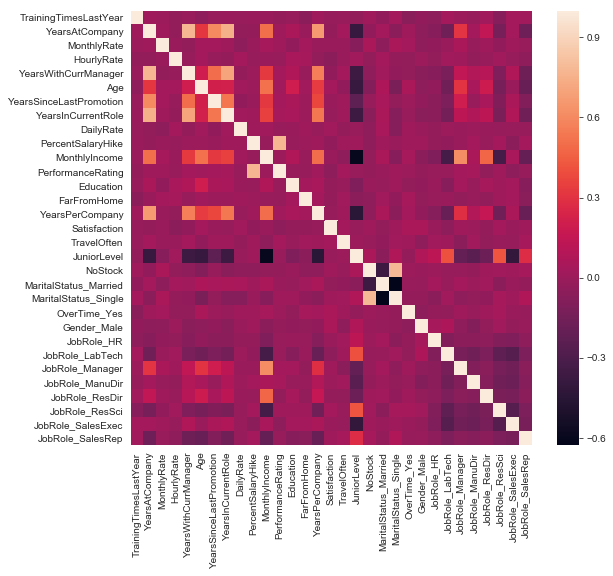

In [18]:
corr = X_train_preprocessed.corr()
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [19]:
def get_correlated_with_cutoff(corr_matrix, cutoff):
    """
    get the pairs of variables with correlations higher than the cutoff
    """
    corr_df =  abs(corr_matrix.unstack().sort_values(ascending=False).drop_duplicates())
    filtered_df = corr_df[(corr_df < 1) & (corr_df > cutoff)]
    
    links = (corr > cutoff).sum() -1
    
    return filtered_df, set(chain(*filtered_df.index)), links[links > 0]

corr_df, corr_items, corr_links = get_correlated_with_cutoff(corr, .7)

print('Highly Correlated Features:', end='\n\n')
print(corr_df)

Highly Correlated Features:

MaritalStatus_Single  NoStock                 0.788
YearsWithCurrManager  YearsAtCompany          0.776
PercentSalaryHike     PerformanceRating       0.774
YearsAtCompany        YearsInCurrentRole      0.747
YearsInCurrentRole    YearsWithCurrManager    0.707
dtype: float64


In [20]:
to_drop_cols = [
    'NoStock',
    'PerformanceRating', 
    'YearsInCurrentRole', 
    'YearsWithCurrManager', 
]

X_train_preprocessed.drop(to_drop_cols, axis=1, inplace=True)
X_test_preprocessed.drop(to_drop_cols, axis=1, inplace=True)

## 4. Build Models
#### 4.1 Choose Metrics

We aimed to build machine learning models that predict whether employees would leave their positions or not. One challenge of this dataset is the inherent imbalance of the attrition data: only a small proportion (16%) of employees have left their jobs. We choose the F1 score as our metric since it combines both recall and precision. Also, because the goal is to identify high-risk employees, recall rate is more important than the precision rate in this project.

#### 4.2 Train and test models

In [21]:
def print_results(model, X_test, y_test):
    """
    print summrized results
    """
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    auc = metrics.roc_auc_score(y_test, y_pred_prob)
    acc = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    conf_mat_df = pd.DataFrame(conf_mat, 
                               index= ['true_no', 'true_yes'],
                              columns = ['predict_no', 'predict_yes'])
    
    model_name = str(model).split('(')[0]
    print(f'{"*" *10} {model_name} {"*" *10}')
    print(f'Accuracy: {acc:.3f}')
    print(f'AUC: {auc:.3f}')
    print(f'F1: {f1:.3f}\n', end='\n')
    print('Confusion Matrix:', end='\n')
    print(conf_mat_df, end='\n\n')
    print('Classification Report:', end='\n')
    print(metrics.classification_report(y_test, y_pred))


def params_tuning(X_train, y_train, X_test, y_test,
                  model=None, param_grid=None,
                 scoring=None, balance_weight=False):
    """
    Use the best params resulted from GridSearchCV to fit models
    """
    if balance_weight:
        sample_weight = y_train.map(dict(0.5 / y_train.value_counts())).values
    else:
        sample_weight = None
    
    # Grid Search for the best parameters
    clf = GridSearchCV(model, param_grid, cv=5, scoring=scoring)
    clf.fit(X_train, y_train, sample_weight=sample_weight)
    # train model with the selected best parameters
    model.set_params(**clf.best_params_)
    model.fit(X_train, y_train)
    # pring results
    print_results(model, X_test, y_test)
    return model

#### 4.2.1 Logistic Regression Classifier

We first trained a Logistic Regression model with L2 regularization to predict employee attritions. The performance was not bad for this simple model.

In [22]:
lr_params = {
    'max_iter': 1000,
    'class_weight': 'balanced'
}
# lr_grid_params = {
#     'C': np.linspace(.1, 1, 10),
#     'penalty': ['l1', 'l2'],
#     'class_weight': ['balanced']
# }

# lr = params_tuning(
#     X_train_preprocessed, y_train,
#     X_test_preprocessed, y_test,
#     model=LogisticRegression(**lr_params),
#     param_grid=lr_grid_params,
#     scoring='f1',
# )

lr_tuned_params = {'penalty': 'l2', 'C': .6}
lr = LogisticRegression(**lr_params, **lr_tuned_params)
lr.fit(X_train_preprocessed, y_train)
print_results(lr, X_test_preprocessed, y_test)

********** LogisticRegression **********
Accuracy: 0.782
AUC: 0.810
F1: 0.500

Confusion Matrix:
          predict_no  predict_yes
true_no          198           49
true_yes          15           32

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       247
           1       0.40      0.68      0.50        47

   micro avg       0.78      0.78      0.78       294
   macro avg       0.66      0.74      0.68       294
weighted avg       0.84      0.78      0.80       294



#### 4.2.2 Random Forest Classifier (with oversampling)
Class imbalance affects Ensemble classifiers a lot. Therefore, we employed the Synthetic Minority Oversampling Technique (SMOTE) before model training. On the testing set, random forest classifier showed the highest accuracy among all the tested models. However, this classifier had a low recall rate.

In [23]:
oversampler=SMOTE(random_state=0)
X_train_smote, y_train_smote = oversampler.fit_sample(
    X_train_preprocessed, y_train)

rf_params = {
    'n_jobs': -1,
    'n_estimators': 1000,
    'min_samples_leaf': 2,
    'verbose': 0,
    'oob_score': True,
}

#rf_grid_params = {
#     'max_depth': [2, 5, 8, 12],
#     'max_features': [.3, .5, .8]
#                  }

# rf = params_tuning(
#     X_train_smote, y_train_smote,
#     X_test_preprocessed, y_test,
#     model=RandomForestClassifier(**rf_params),
#     param_grid=rf_grid_params,
#     scoring='f1',
# )

rf_tuned_params = {'max_depth': 12, 'max_features': .3}
rf = RandomForestClassifier(**rf_params, **rf_tuned_params)
rf.fit(X_train_smote, y_train_smote)
print_results(rf, X_test_preprocessed, y_test)

********** RandomForestClassifier **********
Accuracy: 0.878
AUC: 0.787
F1: 0.514

Confusion Matrix:
          predict_no  predict_yes
true_no          239            8
true_yes          28           19

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       247
           1       0.70      0.40      0.51        47

   micro avg       0.88      0.88      0.88       294
   macro avg       0.80      0.69      0.72       294
weighted avg       0.86      0.88      0.86       294



#### 4.2.3 Gradient Boosting Classifier(with oversampling)

Though Gradient Boosting Classifier showed high accuracy, it didn't perform well on AUC and F1 scoring, which are more important metrics for imbalanced datasets.

In [24]:
gb_params = {
    'n_estimators': 1000,
    'min_samples_leaf': 2,
}
# gb_grid_params = {'learning_rate': np.linspace(.1, 1, 10),
#                  'max_depth': [2, 3, 5, 8],
#                  'max_features': [.3, .5, .8]}

# gb = params_tuning(
#     X_train_smote, y_train_smote,
#     X_test_preprocessed, y_test,
#     model=GradientBoostingClassifier(**gb_params),
#     param_grid=gb_grid_params,
#     scoring='f1',
# )

gb_tuned_params = {'max_depth': 8, 'max_features': .3, 'learning_rate': 0.4}
gb = GradientBoostingClassifier(**gb_params, **gb_tuned_params)
gb.fit(X_train_smote, y_train_smote)
print_results(gb, X_test_preprocessed, y_test)

********** GradientBoostingClassifier **********
Accuracy: 0.847
AUC: 0.732
F1: 0.384

Confusion Matrix:
          predict_no  predict_yes
true_no          235           12
true_yes          33           14

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       247
           1       0.54      0.30      0.38        47

   micro avg       0.85      0.85      0.85       294
   macro avg       0.71      0.62      0.65       294
weighted avg       0.82      0.85      0.83       294



#### 4.2.4 Support Vector Classifier

We then trained and tested a Support Vector Classifier with a linear kernel and balanced class weights; it showed the highest AUC score and F1 score among the examined machine learning models. Though, in comparison with the Logistic regression model, the feature weights of SVC were harder to interpret.

In [25]:
from sklearn.svm import SVC

svc_params = {
    'cache_size': 200, 
    'kernel': 'linear',
    'gamma': 'auto',
    'class_weight': 'balanced',
    'probability': True
}
# svc_grid_params = {'C': [.05, .1, .2, .5, 1, 2, 5, 10, 20]}

# svc = params_tuning(
#     X_train_preprocessed, y_train,
#     X_test_preprocessed, y_test,
#     model=SVC(**svc_params),
#     param_grid=svc_grid_params,
#     scoring='f1',
# )

svc_tuned_params = {'C': 10}
svc = SVC(**svc_params, **svc_tuned_params)
svc.fit(X_train_preprocessed, y_train)
print_results(svc, X_test_preprocessed, y_test)

********** SVC **********
Accuracy: 0.799
AUC: 0.820
F1: 0.528

Confusion Matrix:
          predict_no  predict_yes
true_no          202           45
true_yes          14           33

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87       247
           1       0.42      0.70      0.53        47

   micro avg       0.80      0.80      0.80       294
   macro avg       0.68      0.76      0.70       294
weighted avg       0.85      0.80      0.82       294



#### 4.2.5 Majority Voting Classifier

We combined the predictions of the models with decent performance (Logistic Regression, Random Forest, and SVC) and took the majority vote. This hard voting Classifier showed even higher F1 score than the best classifier (SVC) in the ensemble.

In [26]:
class VotingClassifier:
    def __init__(self, models):
        self.models = models
        
    def __repr__(self):
        model_info = ', '.join(list(models.keys()))
        return f'EnsembleVoting({model_info})'
    
    def predict(self, X_test):
        predictions = [model.predict(X_test) for model in self.models.values()]
        return np.array(predictions).mean(0) > .5
        
    def predict_proba(self, X_test):
        prob= [model.predict_proba(X_test) for model in models.values()]
        return np.stack(prob).mean(0)
        
        
models = {
    'Logistic Regression': lr, 
    'Random Forest': rf,
    'SVC': svc,
    }
vt = VotingClassifier(models)
print_results(vt, X_test_preprocessed, y_test)

********** EnsembleVoting **********
Accuracy: 0.810
AUC: 0.817
F1: 0.533

Confusion Matrix:
          predict_no  predict_yes
true_no          206           41
true_yes          15           32

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       247
           1       0.44      0.68      0.53        47

   micro avg       0.81      0.81      0.81       294
   macro avg       0.69      0.76      0.71       294
weighted avg       0.85      0.81      0.82       294



#### 4.3 Bechmark Classifiers

Benchmark Results:
                     Accuracy  ROC AUC     F1
Logistic Regression     0.782    0.810  0.500
Random Forest           0.878    0.787  0.514
SVC                     0.799    0.820  0.528
Ensemble                0.810    0.817  0.533



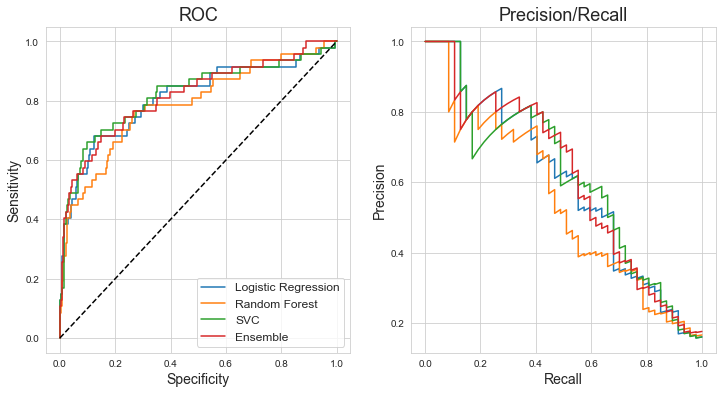

In [36]:
def plot_curves(y_test, y_pred_prob, ax1, ax2):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    pr, rc, _ = metrics.precision_recall_curve(y_test, y_pred_prob)
    ax1.plot(fpr, tpr)
    ax2.plot(rc, pr)
    

def get_model_results(y_test, y_pred, y_pred_prob):
    return pd.Series({
        'Accuracy': metrics.accuracy_score(y_test, y_pred),
        'ROC AUC': metrics.roc_auc_score(y_test, y_pred_prob),
        'F1': metrics.f1_score(y_test, y_pred),
    })
    

def plot_comparison(models, X_test, y_test):
    """
    Plot ROC and Precision/Recall Curves
    """
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    df_results = pd.DataFrame()
    for name, model in models.items():
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        plot_curves(y_test, y_pred_prob, ax1, ax2)
        df_results[name] = get_model_results(y_test, y_pred, y_pred_prob)

    ax1.set_xlabel('Specificity', fontsize=14)
    ax1.set_ylabel('Sensitivity', fontsize=14)
    ax1.set_title('ROC', fontsize=18)
    ax1.legend(handles=ax1.lines, labels=list(models.keys()), fontsize=12)
    ax1.plot([0, 1], [0, 1], 'k--')

    ax2.set_xlabel('Recall', fontsize=14)
    ax2.set_ylabel('Precision', fontsize=14)
    ax2.set_title('Precision/Recall', fontsize=18)
    
    print("Benchmark Results:")
    print(df_results.T, end='\n\n')
    #ax[1].legend(handles=ax[1].lines, labels=list(models.keys()), fontsize=12)
    
    # bechmark results
#     df_results = df_results.unstack().reset_index()
#     df_results.columns = ['models', 'metrics', 'values']
#     sns.factorplot(x='metrics', y='values', hue='models',
#                     data=df_results, kind='bar', ax=ax3,
#                   legend_out=True)
#     ax3.set_ylim(0,1)
#     ax3.set_title('Benchmak Model Performance', fontsize=18)
#     ax3.set_ylabel('')
#     ax3.set_xlabel('')
#     ax3.set_xticklabels(ax3.get_xticklabels(), fontsize=14)
#     ax3.legend(bbox_to_anchor=(.7, 1), loc=2, borderaxespad=0., fontsize=12)
#     plt.close(2)
#     plt.subplots_adjust(hspace=.4)

    
compare_models = models.copy()
compare_models['Ensemble'] = vt
plot_comparison(compare_models, X_test_preprocessed, y_test)


The benchmark analysis revealed better performance (F1, AUC score) in SVC than in Logistic Regression and Random Forest model. Though Random Forest classifier showed highest classification accuracy, it tent to classify employees as without attritions, causing low recall rate. However, since the goal of this project is to identify the employees with high attrition risk (minority class), it is more important to consider recall than precision. 

Next, we combined the three models with majority voting. This classifier further enhanced the performance on F1 score. 

#### 4.4 Feature Importance

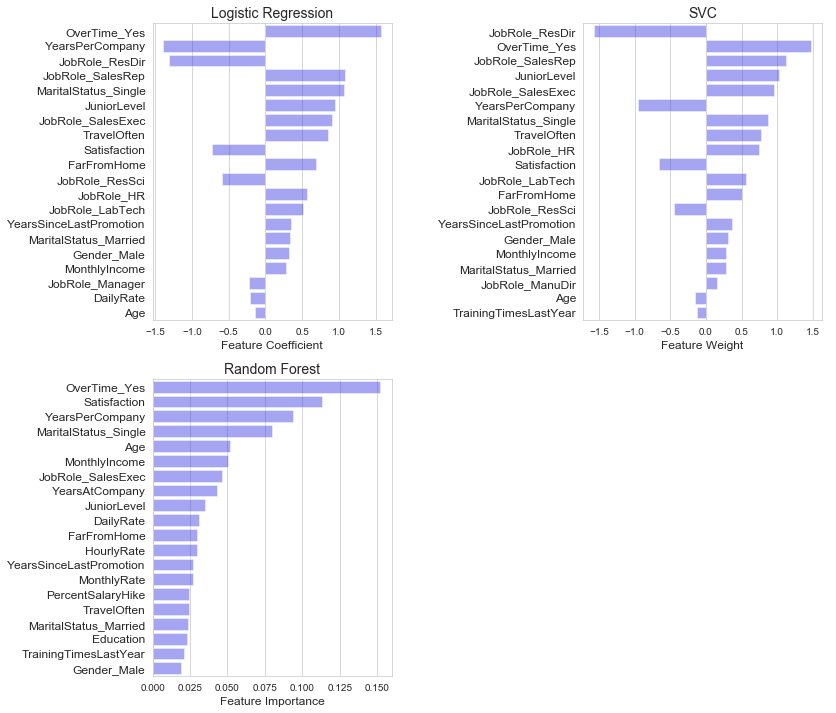

In [37]:
def plot_feature_importance(features, importance, 
                            topN=20, ax=None):

    df = pd.DataFrame({'features': features, 
                  'importance': importance})
    df['abs_importance'] = abs(df['importance'])
    df.sort_values('abs_importance', inplace=True, ascending=False)
    
    sns.barplot(y="features", x="importance", data=df[:20], 
                color="b", alpha=.4, ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel("")
    ax.set_xlabel("")
    

model_feature_info ={
    'Logistic Regression': ('Coef', lr.coef_[0] ),
    'SVC': ('Coef', svc.coef_[0] ),
    'Random Forest': ('Feature Importance', rf.feature_importances_)
}

def compare_feature_importance(model_feature_info):
    col_n, ph, pw = 2, 6, 6
    model_n = len(model_feature_info)
    row_n = int(np.ceil( model_n / col_n))
    
    f, ax = plt.subplots(row_n, col_n, 
                         figsize=(col_n * ph, row_n * pw))
    ax = ax.ravel()
    
    features = list(X_test_preprocessed.columns)
    for i, (model_name, model_info) in enumerate(model_feature_info.items()):
        plot_feature_importance(
            features, model_info[1], ax=ax[i])
        ax[i].set_title(model_name, fontsize=14)
        ax[i].set_xlabel(model_info[0], fontsize=12)
        
    plt.subplots_adjust(wspace=0.8)
    
    for ax in ax[model_n:]:
        ax.axis('off')

model_feature_info ={
    'Logistic Regression': ('Feature Coefficient', lr.coef_[0] ),
    'SVC': ('Feature Weight', svc.coef_[0] ),
    'Random Forest': ('Feature Importance', rf.feature_importances_)
}
compare_feature_importance(model_feature_info)

 In some scenarios, a complicated black box model with the best performance is all we need. This project, however, was not the case. The **interpretability** of the model is equally critical since HR would rely on these insights to devise intervention strategies. 

Though the exact feature importance levels differ among the three examined models, their patterns share a lot in common.  

1. Several working environment factors were associated with higher attrition risks: such as working overtime, living far away from the company, lack of satisfaction, and traveling a lot. 
2. Some job roles, such as sales and HR, had higher attrition risks; in contrast, research scientists and directors showed lower risks. Also, employees in junior level positions were more likely to leave their jobs. 
3. Some personal attributes also contributed to the attrition risks, such as single, young age, and a history of short stays at each worked company.

Though formulating policies to increase retention is beyond the scope of this project, we could draw some actionable insights. Such as:

1. Give recognition or compensations to the employees who have been working overtime, or spending a lot of time in commute or traveling
2. Allocate more resources to the departments with low retention rate for team and culture building
3. Provide more guidance (orientation, mentorship) to junior employees